# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json


%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
response_btc = requests.get(btc_url)
btc_data = response_btc.json()
# Fetch current ETH price
response_eth = requests.get(eth_url)
eth_data = response_eth.json()

In [6]:
# Compute current value of my crpto
##BTC
if response_btc.status_code == 200:
    my_btc_value = my_btc * btc_data['data']['1']['quotes']['USD']['price']
    
##ETH
if response_eth.status_code == 200:
    my_eth_value = my_eth * eth_data['data']['1027']['quotes']['USD']['price']

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $55434.00
The current value of your 5.3 ETH is $12992.26


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2024-02-02", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
stocks_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df


# Reorganize the DataFrame
# Separate ticker data and pick AGG and SPY close prices
AGG = stocks_df[stocks_df['symbol'] == 'AGG'][['close']]
SPY = stocks_df[stocks_df['symbol'] == 'SPY'][['close']]



# Concatenate the ticker DataFrames
combined_df = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Drop the time component of the date
combined_df.index = combined_df.index.date

# Preview DataFrame
combined_df

,AGG,SPY
,close,close
2024-02-02,98.46,494.35


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * combined_df['AGG']['close'][0]
my_spy_value = my_spy * combined_df['SPY']['close'][0]

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $24717.50
The current value of your 200 AGG shares is $19692.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Calculate total value of crypto assets
crypto_total_value = my_btc_value + my_eth_value

# Calculate total value of shares
shares_total_value = my_agg_value + my_spy_value

# Consolidate financial assets data
asset_data = {'amount': [crypto_total_value, shares_total_value]}

# Create savings DataFrame
df_savings = pd.DataFrame(asset_data, index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)


,amount
crypto,68426.261
shares,44409.500


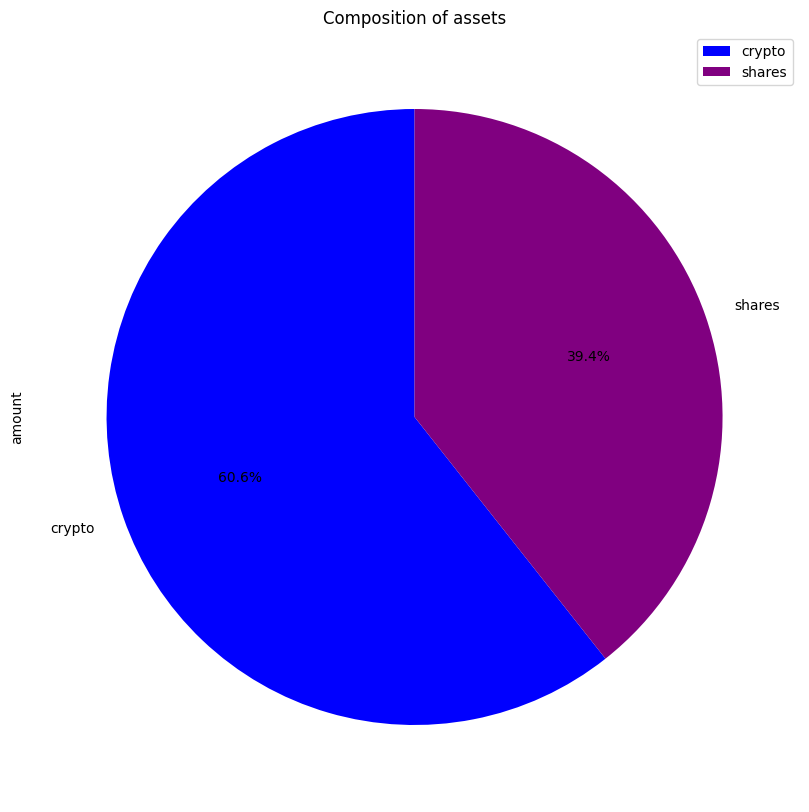

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', autopct='%1.1f%%', startangle=90, legend=True, figsize=(10, 10), colors=['blue', 'purple'], title="Composition of assets");



In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto_total_value + shares_total_value

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_savings == emergency_fund:
    print("Congratulations! You have reached your financial goal for the emergency fund.")
else:
    dollars_away = emergency_fund - total_savings
    print(f"You are ${dollars_away:0.2f} away from reaching your emergency fund goal.")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2019-01-20', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2024-01-20', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
# Set timeframe to "1Day"
timeframe = "1Day"

# Set the ticker information
tickers = ["SPY","AGG"]

df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)[['close']]
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)[['close']]


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])

# Display sample data
df_stock_data.head()

,SPY,AGG
,close,close
timestamp,,
2019-01-22 05:00:00+00:00,262.94,106.44
2019-01-23 05:00:00+00:00,263.35,106.55
2019-01-24 05:00:00+00:00,263.60,106.73
2019-01-25 05:00:00+00:00,265.78,106.68
2019-01-28 05:00:00+00:00,263.78,106.62


In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30y = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_30y.portfolio_data.head()

SPY                  AGG             
                            close daily_return   close daily_return
timestamp                                                          
2019-01-22 05:00:00+00:00  262.94          NaN  106.44          NaN
2019-01-23 05:00:00+00:00  263.35     0.001559  106.55     0.001033
2019-01-24 05:00:00+00:00  263.60     0.000949  106.73     0.001689
2019-01-25 05:00:00+00:00  265.78     0.008270  106.68    -0.000468
2019-01-28 05:00:00+00:00  263.78    -0.007525  106.62    -0.000562

In [ ]:
# Run a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30y.calc_cumulative_return()

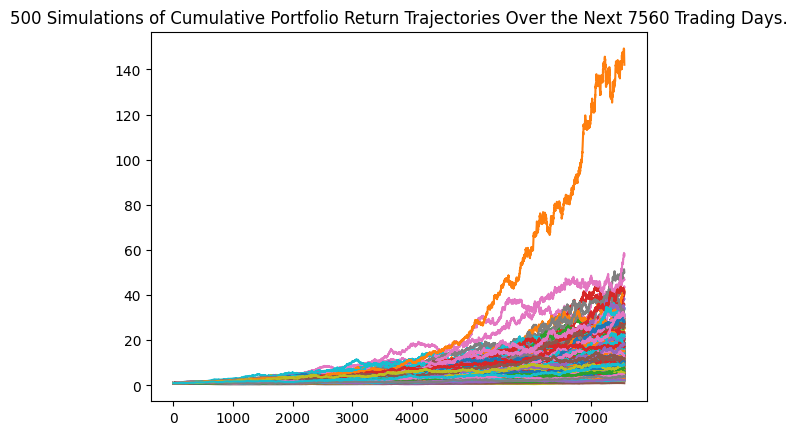

In [19]:
# Plot simulation outcomes
sim_plot = MC_30y.plot_simulation()

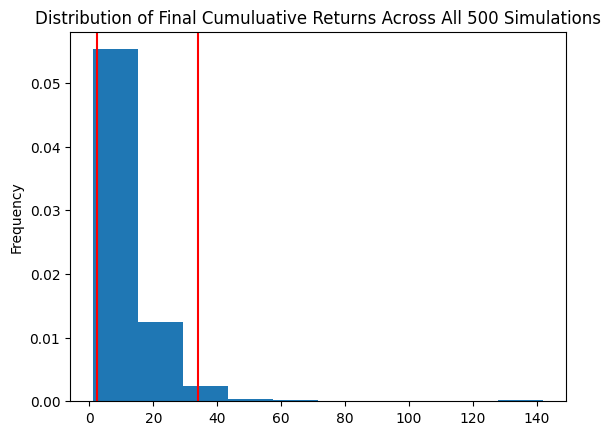

In [20]:
# Plot probability distribution and confidence intervals
distribution_plot = MC_30y.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
table = MC_30y.summarize_cumulative_return()
print(table)

count           500.000000
mean             11.495369
std              10.002565
min               0.964455
25%               5.596531
50%               9.273087
75%              14.382611
max             142.070692
95% CI Lower      2.304975
95% CI Upper     33.913703
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(table[8]*20000,2)
ci_upper = round(table[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $46099.5 and $678274.07


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(table[8]*20000*1.5,2)
ci_upper = round(table[9]*20000*1.5,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $69149.25 and $1017411.1


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns

MC_5y = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5y.calc_cumulative_return()

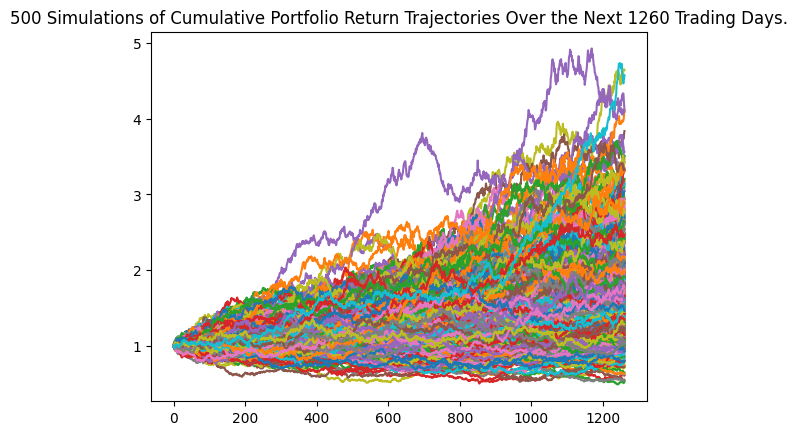

In [26]:
# Plot simulation outcomes
sim_plot_5 = MC_5y.plot_simulation()

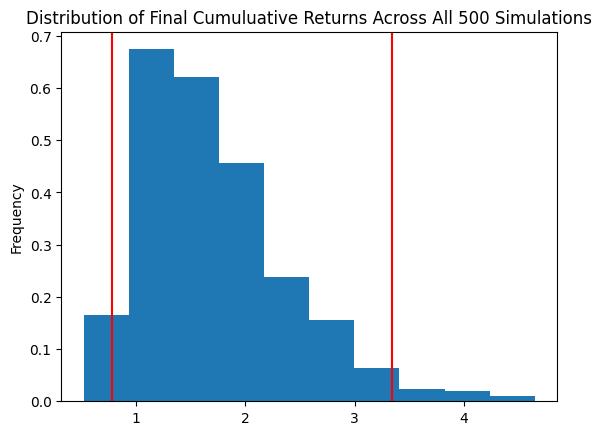

In [27]:
# Plot probability distribution and confidence intervals
distribution_plot_5 = MC_5y.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
table_5y = MC_5y.summarize_cumulative_return()

# Print summary statistics
print(table_5y)

count           500.000000
mean              1.714900
std               0.676656
min               0.522425
25%               1.233985
50%               1.553622
75%               2.087467
max               4.645707
95% CI Lower      0.780500
95% CI Upper      3.337200
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment = 50000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(table[8]*50000,2)
ci_upper_five = round(table[9]*50000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $50000 in the portfolio over the next 5 years will end within in the range of $115248.75 and $1695685.17


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.70,.30],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y.calc_cumulative_return()

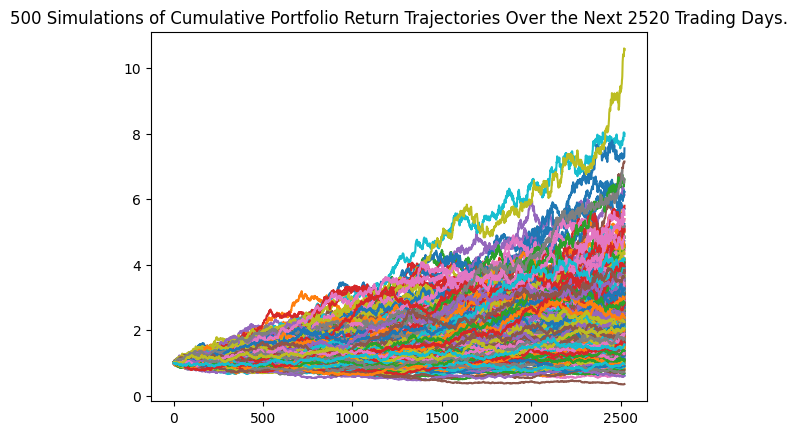

In [32]:
# Plot simulation outcomes
sim_plot_10 = MC_10y.plot_simulation()

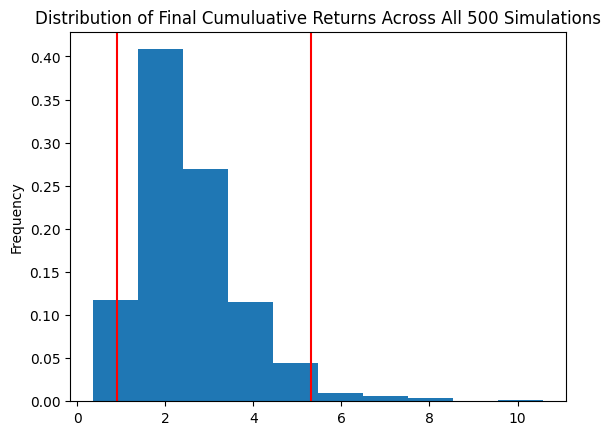

In [33]:
# Plot probability distribution and confidence intervals
distribution_plot_10 = MC_10y.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
table_10y = MC_10y.summarize_cumulative_return()

# Print summary statistics
print(table_10y)

count           500.000000
mean              2.552823
std               1.192104
min               0.350735
25%               1.744774
50%               2.288491
75%               3.139494
max              10.588932
95% CI Lower      0.904037
95% CI Upper      5.320668
Name: 2520, dtype: float64


In [35]:
# Set initial investment
initial_investment = 150000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(table[8]*150000,2)
ci_upper_ten = round(table[9]*150000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $150000 in the portfolio over the next 10 years will end within in the range of $345746.26 and $5087055.5
